## Data Preprocessing and imports

In [78]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Loading (as in notebook) ---
base_path = "../data/"
files = {
    "contribution": ("Zusatzbeitrag_je Kasse je Quartal.xlsx", "Sheet1"),
    "morbidity": ("Morbidity_Region.xlsx", "data"),
    "market": ("Marktanteile je Kasse.xlsx", "data")
}

dataframes = {}
for name, (filename, sheetname) in files.items():
    full_path = os.path.join(base_path, filename)
    merged = pd.read_excel(full_path, sheet_name=sheetname)
    dataframes[name] = merged
for merged in dataframes.values():
    merged["Krankenkasse"] = merged["Krankenkasse"].str.strip().str.lower()
    merged["Jahr"] = merged["Jahr"].astype(int)

manual_fixes = {
    'bkk dürkopp adler': 'bkk dürkoppadler',                     # consistent spelling
    'bkk der mtu friedrichshafen': 'bkk mtu',                    # full official name
    'ikk - die innovationskasse': 'ikk – die innovationskasse',  # unify dash
    'hanseatische krankenkasse (hek)': 'hek',                    # full name
    'techniker krankenkasse (tk)': 'techniker-krankenkasse (tk)',# unify name
    'bkk metzinger': 'metzinger bkk'                             # consistent spelling
}

dataframes["morbidity"]["Krankenkasse"] = dataframes["morbidity"]["Krankenkasse"].replace(manual_fixes)

# Apply these 8 manual fixes to market
dataframes["market"]["Krankenkasse"] = dataframes["market"]["Krankenkasse"].replace(manual_fixes)


## Feature Engineering

This section creates new features to improve model performance:

- **Churn Calculation:**  
  Calculates the absolute and relative change in members (`churn_abs`, `churn_rel`) for each fund (`Krankenkasse`) per quarter.

- **Contribution Rate Change:**  
  Computes the change in `Zusatzbeitrag` (contribution rate) from the previous quarter for each fund.

- **Competitor Contribution:**  
  - `competitor_contribution`: For each fund in a given year and quarter, computes the mean `Zusatzbeitrag` of all *other* funds (excluding itself).
  - `competitor_contrib`: Uses a k-nearest neighbors (KNN) approach based on `Mitglieder`, `Zusatzbeitrag`, `Jahr`, and `Quartal` to compute a mean competitor contribution, considering the 10 most similar funds in the same period.
- **Remove Data of insurance Funds who don't have records till 2025**

These features help capture both the fund's own trends and its competitive environment, which are important for predicting churn and contribution rates.

In [79]:
merged = pd.merge(
    dataframes["contribution"],
    dataframes["morbidity"][["Krankenkasse", "Jahr", "Risikofaktor"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)
merged = pd.merge(
    merged,
    dataframes["market"][["Krankenkasse", "Jahr", "Marktanteil Mitglieder", "Marktanteil Versicherte"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)

# Drop rows with missing 'Mitglieder' or 'Zusatzbeitrag'
merged = merged.dropna(subset=['Mitglieder', 'Zusatzbeitrag'])

# --- 2. Feature Engineering ---
# Sort and calculate churn. Negative churn means a decrease in members.
merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
merged['members_prev'] = merged.groupby('Krankenkasse')['Mitglieder'].shift(1)
merged['churn_abs'] = merged['Mitglieder'] - merged['members_prev']
merged['churn_rel'] = merged['churn_abs'] / merged['members_prev'] * 100

# Contribution rate change
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
merged['rate_change'] = merged['Zusatzbeitrag'] - merged['Zusatzbeitrag_prev']

Computing Competitor Contribution, based on 'Mitglieder', 'Zusatzbeitrag', 'Jahr', 'Quartal'

In [80]:
from sklearn.metrics import pairwise_distances
def compute_competitor_contribution(df):
    # For each row, compute the mean contribution of all other funds in the same year/quarter
    df['competitor_contribution'] = df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform(lambda x: (x.sum() - x) / (len(x) - 1))
    return df
def compute_competitor_contrib_knn(df: pd.DataFrame) -> pd.Series:
    df = df.copy()
    contrib_values = {}

    df_reset = df.reset_index()  # Keep original index in a column
    df_reset['_orig_index'] = df.index  # Save original index before drop=True

    for (jahr, quartal), group in df_reset.groupby(['Jahr', 'Quartal']):
        group = group.reset_index(drop=True)  # This index is temporary
        features = group[['Mitglieder', 'Zusatzbeitrag', 'Jahr', 'Quartal']].to_numpy()

        # Compute pairwise Euclidean distances
        dists = pairwise_distances(features, metric='euclidean')

        for i, row in group.iterrows():
            dist_to_others = dists[i].copy()
            dist_to_others[i] = np.inf  # ignore self

            top_k_indices = np.argsort(dist_to_others)[:10]
            mean_contrib = group.loc[top_k_indices, 'Zusatzbeitrag'].mean()

            orig_idx = row['_orig_index']
            contrib_values[orig_idx] = mean_contrib

    # Return as Series with proper index matching df
    contrib_series = pd.Series(contrib_values, index=df.index)
    
    # Fill any missing values with overall mean or some fallback
    contrib_series = contrib_series.fillna(df['Zusatzbeitrag'].mean())

    return contrib_series

def filter_funds_with_2025_q1(df: pd.DataFrame) -> pd.DataFrame:
    required_quarter = pd.to_datetime("2025Q1")
    valid_funds = df[df.index == required_quarter]['Krankenkasse'].unique()
    return df[df['Krankenkasse'].isin(valid_funds)].copy()

merged['Risikofaktor'] = pd.to_numeric(merged['Risikofaktor'], errors='coerce')
merged['Marktanteil Mitglieder'] = pd.to_numeric(merged['Marktanteil Mitglieder'], errors='coerce')
merged['Zusatzbeitrag'] = pd.to_numeric(merged['Zusatzbeitrag'], errors='coerce')
merged = compute_competitor_contribution(merged)
merged['competitor_contribution'] = pd.to_numeric(merged['competitor_contribution'], errors='coerce')
merged['competitor_contrib'] = compute_competitor_contrib_knn(merged)

merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
merged['date'] = pd.to_datetime(merged['Jahr'].astype(str) + 'Q' + merged['Quartal'].astype(str))
merged.set_index('date', inplace=True)
merged = filter_funds_with_2025_q1(merged)

merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
merged['Zusatz_diff'] = merged['Zusatzbeitrag'] - merged['competitor_contrib']
merged['is_start_of_year'] = (merged['Quartal'] == 1).astype(int)
# merged['date'] = pd.to_datetime(merged['Jahr'].astype(str) + 'Q' + merged['Quartal'].astype(str))
# merged.set_index('date', inplace=True)


# # Drop rows with missing values in key features
features = ['Zusatzbeitrag', 'competitor_contrib']

merged = merged.dropna(subset=features + ['churn_rel', 'Risikofaktor', 'Mitglieder'])

## Visual Comparison of Competitor Features

The following plot provides a visual comparison between the two engineered competitor features and the actual contribution rate:

- **competitor_contribution:** The mean Zusatzbeitrag (contribution rate) of all other funds in the same quarter, excluding the fund itself.
- **competitor_contrib:** The mean Zusatzbeitrag of the 10 most similar funds (using a KNN approach based on members, contribution, year, and quarter).
- **Zusatzbeitrag:** The actual contribution rate for the fund.

The scatter plot shows:
- The relationship between `competitor_contribution` and `competitor_contrib` (blue dots).
- The actual `Zusatzbeitrag` overlaid against `competitor_contribution` (green Xs).
- The red dashed line (`y = x`) indicates where the two competitor features would be equal.

Below the plot, the mean absolute differences between each pair of these features are printed. This helps to quantify how similar or different these engineered features are from each other and from the actual contribution rate.

We used competitor_contrib the KNNs methodology, as it was better for forecasting, and moreover it didn't have much difference with average competitor contribution values.

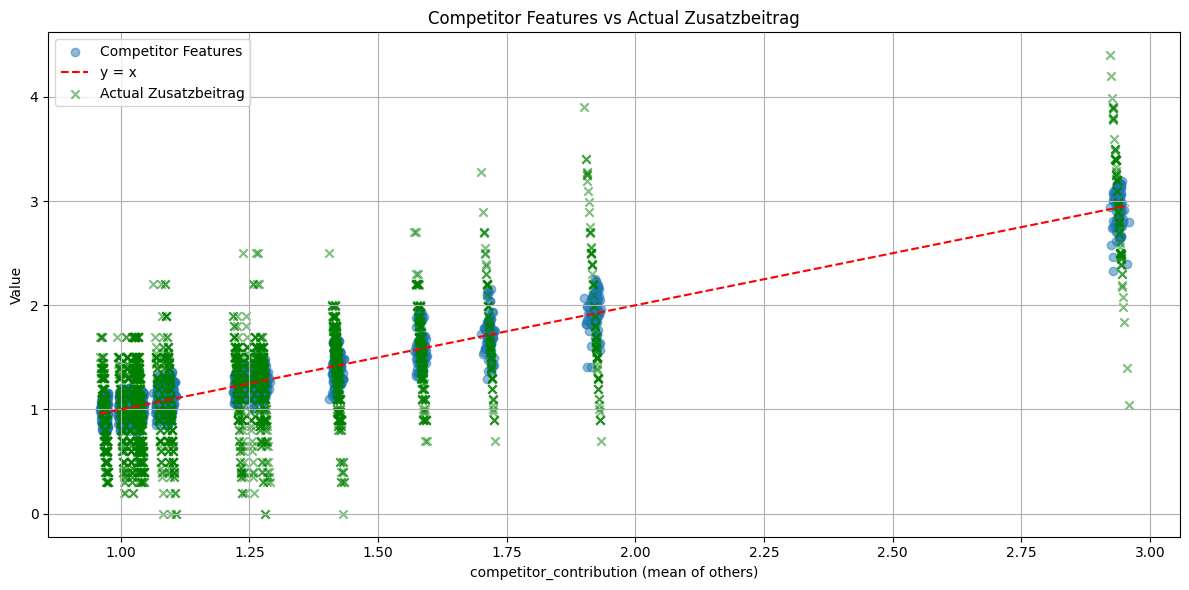

Mean absolute difference (competitor_contribution vs competitor_contrib_knn): 0.0811
Mean absolute difference (competitor_contribution vs Zusatzbeitrag): 0.2625
Mean absolute difference (competitor_contrib_knn vs Zusatzbeitrag): 0.2786


In [81]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Scatter plot: competitor_contribution vs competitor_contrib
plt.scatter(
    merged['competitor_contribution'], merged['competitor_contrib'],
    alpha=0.5, label='Competitor Features'
)

# Red dashed line: y = x
plt.plot(
    [merged['competitor_contribution'].min(), merged['competitor_contribution'].max()],
    [merged['competitor_contribution'].min(), merged['competitor_contribution'].max()],
    'r--', label='y = x'
)

# Overlay: actual Zusatzbeitrag vs competitor_contribution
plt.scatter(
    merged['competitor_contribution'], merged['Zusatzbeitrag'],
    alpha=0.5, color='green', marker='x', label='Actual Zusatzbeitrag'
)

plt.xlabel('competitor_contribution (mean of others)')
plt.ylabel('Value')
plt.title('Competitor Features vs Actual Zusatzbeitrag')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate mean differences
mean_diff_contrib = np.mean(np.abs(merged['competitor_contribution'] - merged['competitor_contrib']))
mean_diff_actual = np.mean(np.abs(merged['competitor_contribution'] - merged['Zusatzbeitrag']))
mean_diff_knn_actual = np.mean(np.abs(merged['competitor_contrib'] - merged['Zusatzbeitrag']))

print(f"Mean absolute difference (competitor_contribution vs competitor_contrib_knn): {mean_diff_contrib:.4f}")
print(f"Mean absolute difference (competitor_contribution vs Zusatzbeitrag): {mean_diff_actual:.4f}")
print(f"Mean absolute difference (competitor_contrib_knn vs Zusatzbeitrag): {mean_diff_knn_actual:.4f}")

### Creating Test and Train set

In [82]:
from sklearn.model_selection import train_test_split

additional_features = ['Risikofaktor', 'Mitglieder']
features.extend(['Zusatzbeitrag_prev', 'Zusatz_diff'])
X = merged[features]
y = merged['churn_rel']

X_additional = merged[features + additional_features]
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_additional, X_test_additional, y_train_additional, y_additional = train_test_split(X_additional, y, test_size=0.2, random_state=42)

## Model Training and Evaluation

The following code block trains and evaluates a variety of regression models to predict the relative churn (`churn_rel`) for each fund and quarter using the engineered features. The models include linear models, tree-based models, ensemble methods, support vector regression, neural networks, and gradient boosting frameworks.

- The code splits the data into training and test sets.
- Each model is trained and evaluated twice:
  - First, using the base set of engineered features.
  - Second, using an extended feature set that includes additional variables such as `Risikofaktor` and `Mitglieder`.
- For each model and feature set, the Root Mean Squared Error (RMSE) and R² score are calculated to assess prediction accuracy.
- Results for both feature sets are collected and displayed side-by-side in a formatted table for easy comparison.

The Improvements in accuracy can be seen after adding each features. The data preprocessing and model training in UI code is a bit more optimized and has better accuracy. Go to streamlit UI to walk through different models and their accuracies.

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate

# Regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(max_iter=10000),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(    l2_regularization=0,
    learning_rate=0.05,
    max_depth=7,
    max_iter=100),
    "SVR": SVR(),
    "MLPRegressor": MLPRegressor(max_iter=500),
    "KernelRidge": KernelRidge(),
    "XGBRegressor": XGBRegressor(verbosity=0, n_estimators=1000, random_state=42),
    "LGBMRegressor": LGBMRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0),
}

# Results
results = []

print("\nTraining and evaluating models...\n")
results = []
results_additional = []

for name, model in models.items():
    # Base features
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append((name, round(rmse, 3), round(r2, 3)))
    except Exception as e:
        results.append((name, "Error", str(e)))
    
    # # Additional features
    try:
        model.fit(X_train_additional, y_train_additional)
        y_pred_add = model.predict(X_test_additional)
        rmse_add = np.sqrt(mean_squared_error(y_additional, y_pred_add))
        r2_add = r2_score(y_additional, y_pred_add)
        results_additional.append((name, round(rmse_add, 3), round(r2_add, 3)))
    except Exception as e:
        results_additional.append((name, "Error", str(e)))

# Display as tables
df_results = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
df_results_add = pd.DataFrame(results_additional, columns=["Model", "RMSE (add)", "R² (add)"])

# Merge for side-by-side comparison
df_compare = pd.merge(df_results, df_results_add, on="Model", how="outer")
print(tabulate(df_compare, headers='keys', tablefmt='fancy_grid'))


Training and evaluating models...

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 2752, number of used features: 4
[LightGBM] [Info] Start training from score 0.513227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 2752, number of used features: 6
[LightGBM] [Info] Start training from score 0.513227
╒════╤══════════════════════╤════════╤════════╤══════════════╤════════════╕
│    │ Model                │   RMSE │     R² │   RMSE (add) │   R² (add) │
╞════╪══════════════════════╪════════╪════════╪══════════════╪═══════

## Save Model in Pickle format
Using HistGradientBoostings trained on additional params data, as that was the best model. We used the model used in ```ml_churn_code.py``` as they were the ones performing the best. This same code was used to create a pickle file

In [54]:
# import pickle
# with open('predictive_model_with_additional_params.pkl', 'wb') as file:
#     pickle.dump(models["HistGradientBoosting"], file)
